In [39]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [40]:
#Loads up all the 70k images from the mnist dataset
mnist = fetch_openml('mnist_784',as_frame=False) 
#openml already splits data into a training set (first 60k) and a test set(last 10k)

In [41]:
X,y = mnist.data,mnist.target

In [42]:
print(X)
print(X.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)


In [43]:
print(y,y.shape)

['5' '0' '4' ... '4' '5' '6'] (70000,)


2


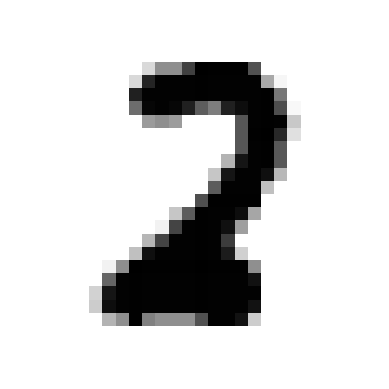

In [44]:
def plot_digit(image_data):
    img= image_data.reshape(28,28)#Size of each image as there are 784 features in each of the 70k images
    plt.imshow(img,cmap="binary")
    plt.axis("off")
digit=X[7960]
plot_digit(digit)
#This is what each image looks like from the data set
#for comparision 
print(y[7960])

In [45]:
#Extracting the pregiven test and train set
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [46]:
#Training a BINARY CLASSIFIER   
y_train_5= (y_train=='5') #True for all 5s ,False for all other digits
y_test_5 = (y_test == '5')

In [47]:
from sklearn.linear_model import SGDClassifier as sdg
sgd_clf=sdg(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [48]:
sgd_clf.predict([digit])

array([False])

In [49]:
#PERFORMANCE MEASURE
#using k fold cross validation with k=3 (this splits the dataset into k folds and trains the model k times holding out a different fold each time for evaluation)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [50]:
#This will have an accuracy of approx 90% this is because out of the 10 digits 
#if each digit gets 10% appearance (which should happen on an evenly distributed dataset)
#Only guessing false allows it to pass all the 90% other cases where the digit is not 5

from sklearn.dummy import DummyClassifier
dum_clf = DummyClassifier()
dum_clf.fit(X_train,y_train_5)
#prints False : no 5s detected 
print(any(dum_clf.predict(X_train)))

False


In [51]:
#This is why accuracy is not the preferred measure for CLASSIFIERS (specially when using skewed datasets)
cross_val_score(dum_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [52]:
#Implementing CROSS-VALIDATION
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)#Adds shuffle=True if the dataset is not already shuffled

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf= clone(sgd_clf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold= y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct= sum(y_pred== y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [53]:
#A much better way to judge the performance of a classifier is to look at a CONFUSION MATRIX
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
#just like the cross_val_score this also makes k fold cross validation
#but instead of giving a the evaluation score this gives the prediction made for each test fold

In [54]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_train_5,y_train_predict)
cm # In a confusion matrix :  Each row -> an actual class 
                            # Each Columns -> a predicted class 

array([[53892,   687],
       [ 1891,  3530]])

In [55]:
# In a perfect world the confusion matrix only shows true positives and True negatives
y_train_prefect_pred= y_train_5
confusion_matrix(y_train_5,y_train_prefect_pred)

array([[54579,     0],
       [    0,  5421]])

In [56]:
#Applying precision and Recall in confusion matrix
# Precision(P) = tp/(TP+FP)
# Recall(R) = Tp/(Tp+Fn)

from sklearn.metrics import precision_score,recall_score
print(f"The Precision of the above classifier model is {precision_score(y_train_5,y_train_predict)}")
print(f"The Recall Value of the above classifier model is {recall_score(y_train_5,y_train_predict)}")

The Precision of the above classifier model is 0.8370879772350012
The Recall Value of the above classifier model is 0.6511713705958311


In [57]:
# A better way for Performance measure of Classifier is to combine the precision and recall score into on :
#F1-Score = 2(PR)/(P+R)
from sklearn.metrics import f1_score
print(f"The F1-Score of the above classifier model is {f1_score(y_train_5,y_train_predict)}")
#Although this tends to prefers a model with similar recall and precision values
#So calculation of f1score is useless when we specifically want low recall or high precision

The F1-Score of the above classifier model is 0.7325171197343847


In [58]:
# THE PRECISION - RECALL TRADEOFF
#increasing the precision of a model often causes a loss in Recall value and vice-versa
y_scores= sgd_clf.decision_function([digit])
print(f"The Score for each instance is :{y_scores}")

The Score for each instance is :[-9974.02473897]


In [59]:
#sgdClassfire uses a threshold equal to 0 so the in this code it return the same result as the predict()method  
threshold= 0
y_digit_pred=(y_scores>threshold)
print(y_digit_pred)

[False]


In [ ]:
#Upon changing the threshold 
threshold= -50000
y_digit_pred=(y_scores>threshold)
print(y_digit_pred)
#this shows that increasing the precision by moving the threshold causes the recall to fall

[ True]


In [64]:
#Deciding the threshold
y_scores= cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
#we use this predict function to get the scores of all instances in the training set but this time we specify that we want to return decision scores instead of direct predictions

Text(0, 0.5, 'PR-Curve')

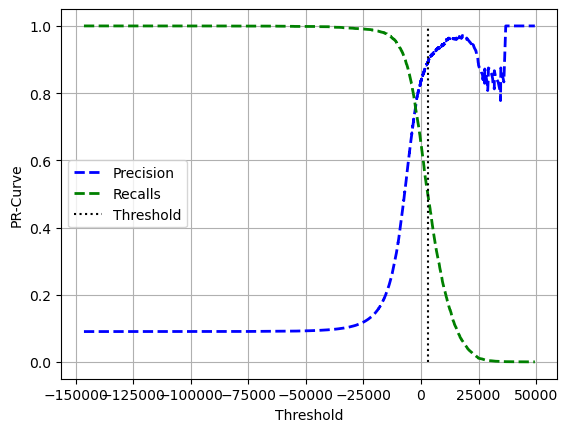

In [ ]:
#With the above scores we use the precision_recall_curve function to compute P and R values for all possible thresholds 
# the functions adds a last precision of 0 and last recall of 1 corresponding to infinite threshold 
from sklearn.metrics import precision_recall_curve
pre,rec,thresholds= precision_recall_curve(y_train_5,y_scores)
threshold=3000
plt.plot(thresholds,pre[:-1],"b--",label="Precision",linewidth=2) 
plt.plot(thresholds,rec[:-1],"g--",label="Recalls",linewidth=2) 
plt.vlines(threshold,0,1.0,"k","dotted",label="Threshold") 
plt.legend()
plt.grid(True)
plt.xlabel("Threshold")
plt.ylabel("PR-Curve")
#this graph will show the relation between the precision and recall with changing threshold and allows for best selections

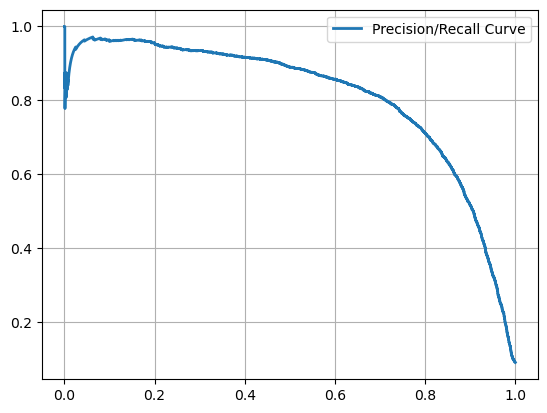

In [ ]:
#Another way is to plot  precision directly against recall 
plt.plot(rec,pre,linewidth=2,label="Precision/Recall Curve")
plt.grid(True)
plt.legend()